In [1]:
import sklearn
from sklearn.naive_bayes import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.discriminant_analysis import *
from sklearn.neural_network import *
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.feature_selection import *

import matplotlib.pyplot as plt
import numpy as np
import itertools as it

import pandas as pd
import openml
from tqdm.notebook import tqdm

from scipy.sparse import lil_matrix

from func_timeout import func_timeout, FunctionTimedOut

In [2]:
def get_dataset(openmlid):
    ds = openml.datasets.get_dataset(openmlid)
    df = ds.get_data()[0].dropna()
    y = df[ds.default_target_attribute].values
    
    categorical_attributes = df.select_dtypes(exclude=['number']).columns
    expansion_size = 1
    for att in categorical_attributes:
        expansion_size *= len(pd.unique(df[att]))
        if expansion_size > 10**5:
            break
    
    if expansion_size < 10**5:
        X = pd.get_dummies(df[[c for c in df.columns if c != ds.default_target_attribute]]).values.astype(float)
    else:
        print("creating SPARSE data")
        dfSparse = pd.get_dummies(df[[c for c in df.columns if c != ds.default_target_attribute]], sparse=True)
        
        print("dummies created, now creating sparse matrix")
        X = lil_matrix(dfSparse.shape, dtype=np.float32)
        for i, col in enumerate(dfSparse.columns):
            ix = dfSparse[col] != 0
            X[np.where(ix), i] = 1
        print("Done. shape is" + str(X.shape))
    return X, y

data_pre_processors = [
    sklearn.preprocessing.MinMaxScaler,
    sklearn.preprocessing.Normalizer,
    sklearn.preprocessing.PowerTransformer,
    sklearn.preprocessing.QuantileTransformer,
    sklearn.preprocessing.RobustScaler,
    sklearn.preprocessing.StandardScaler,
    sklearn.feature_selection._variance_threshold.VarianceThreshold
]
classifiers = [
    sklearn.svm.SVC,
    sklearn.tree.DecisionTreeClassifier,
    sklearn.tree.ExtraTreeClassifier,
    sklearn.linear_model.LogisticRegression,
    #sklearn.linear_model.PassiveAggressiveClassifier,
    #sklearn.linear_model.Perceptron,
    #sklearn.linear_model.RidgeClassifier,
    #sklearn.linear_model.SGDClassifier,
    sklearn.neural_network.MLPClassifier,
    sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
    sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
    sklearn.naive_bayes.BernoulliNB,
    sklearn.naive_bayes.MultinomialNB,
    sklearn.neighbors.KNeighborsClassifier,
    sklearn.ensemble.ExtraTreesClassifier,
    sklearn.ensemble.RandomForestClassifier,
    sklearn.ensemble.GradientBoostingClassifier
    ]

In [3]:
def eval_pipeline(pl, X, y, scoring):
    return np.mean(sklearn.model_selection.cross_validate(pl, X, y, scoring=scoring)["test_score"])

def get_performance_matrix(X, y, scoring, timeout):
    # train all pipelines
    Z = np.zeros((len([None] + data_pre_processors), len(classifiers)))
    for i, pp in enumerate(tqdm([None] + data_pre_processors)):
        for j, classifier in enumerate(classifiers):
            steps=[("pp", pp())] if pp is not None else []
            steps.append(("classifier", classifier() if classifier != sklearn.svm.SVC else classifier(probability=True)))
            print(steps)
            pl = Pipeline(steps)
            try:
                Z[i,j] = func_timeout(timeout, eval_pipeline, (pl, X, y, scoring))
            except FunctionTimedOut:
                Z[i,j] = np.nan
    return Z

In [5]:
Z_31 = get_performance_matrix(*get_dataset(31), "roc_auc", 300)

creating SPARSE data
dummies created, now creating sparse matrix
Done. shape is(1000, 63)


[('classifier', SVC(probability=True))]
[('classifier', DecisionTreeClassifier())]
[('classifier', ExtraTreeClassifier())]
[('classifier', LogisticRegression())]
[('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('classifier', LinearDiscriminantAnalysis())]
[('classifier', QuadraticDiscriminantAnalysis())]
[('classifier', BernoulliNB())]
[('classifier', MultinomialNB())]
[('classifier', KNeighborsClassifier())]
[('classifier', ExtraTreesClassifier())]
[('classifier', RandomForestClassifier())]
[('classifier', GradientBoostingClassifier())]
[('pp', MinMaxScaler()), ('classifier', SVC(probability=True))]
[('pp', MinMaxScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', LogisticRegression())]
[('pp', MinMaxScaler()), ('classifier', MLPClassifier())]
[('pp', MinMaxScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', BernoulliNB())]
[('pp', MinMaxScaler()), ('classifier', MultinomialNB())]
[('pp', MinMaxScaler()), ('classifier', KNeighborsClassifier())]
[('pp', MinMaxScaler()), 

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', Normalizer()), ('classifier', DecisionTreeClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreeClassifier())]
[('pp', Normalizer()), ('classifier', LogisticRegression())]
[('pp', Normalizer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', Normalizer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', BernoulliNB())]
[('pp', Normalizer()), ('classifier', MultinomialNB())]
[('pp', Normalizer()), ('classifier', KNeighborsClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreesClassifier())]
[('pp', Normalizer()), ('classifier', RandomForestClassifier())]
[('pp', Normalizer()), ('classifier', GradientBoostingClassifier())]
[('pp', PowerTransformer()), ('classifier', SVC(probability=True))]
[('pp', PowerTransformer()), ('classifier', DecisionTreeClassifier())]
[('pp', PowerTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', PowerTransformer()), ('classifier', LogisticRegression())]
[('pp', PowerTransformer()), ('classifier', MLPClassifier())]
[('pp', PowerTransformer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', PowerTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


[('pp', QuantileTransformer()), ('classifier', DecisionTreeClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-package

[('pp', QuantileTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-package

[('pp', QuantileTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/h

[('pp', QuantileTransformer()), ('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 509, in fit
    dtype=[np.float64, np.float32])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    r

[('pp', QuantileTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 776, in fit
    X, y = self._validate_data(X, y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    

[('pp', QuantileTransformer()), ('classifier', BernoulliNB())]
[('pp', QuantileTransformer()), ('classifier', MultinomialNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-package

[('pp', QuantileTransformer()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-package

[('pp', QuantileTransformer()), ('classifier', ExtraTreesClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


[('pp', QuantileTransformer()), ('classifier', RandomForestClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-package

[('pp', QuantileTransformer()), ('classifier', GradientBoostingClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-package

[('pp', RobustScaler()), ('classifier', SVC(probability=True))]
[('pp', RobustScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', RobustScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', RobustScaler()), ('classifier', LogisticRegression())]
[('pp', RobustScaler()), ('classifier', MLPClassifier())]
[('pp', RobustScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', RobustScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', RobustScaler()), ('classifier', BernoulliNB())]
[('pp', RobustScaler()), ('classifier', MultinomialNB())]
[('pp', RobustScaler()), ('classifier', KNeighborsClassifier())]
[('pp', RobustScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', RobustScaler()), ('classifier', RandomForestClassifier())]
[('pp', RobustScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', StandardScaler()), ('classifier', SVC(probability=True))]
[('pp', StandardScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', StandardScaler

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', StandardScaler()), ('classifier', KNeighborsClassifier())]
[('pp', StandardScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', StandardScaler()), ('classifier', RandomForestClassifier())]
[('pp', StandardScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', VarianceThreshold()), ('classifier', SVC(probability=True))]
[('pp', VarianceThreshold()), ('classifier', DecisionTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', LogisticRegression())]
[('pp', VarianceThreshold()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', VarianceThreshold()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', BernoulliNB())]
[('pp', VarianceThreshold()), ('classifier', MultinomialNB())]
[('pp', VarianceThreshold()), ('classifier', KNeighborsClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreesClassifier())]
[('pp', VarianceThreshold()), ('classifier', RandomForestClassifier())]
[('pp', VarianceThreshold()), ('classifier', GradientBoostingClassifier())]



In [6]:
Z_iris = get_performance_matrix(*get_dataset(61), "neg_log_loss", 60)

[('classifier', SVC(probability=True))]
[('classifier', DecisionTreeClassifier())]
[('classifier', ExtraTreeClassifier())]
[('classifier', LogisticRegression())]
[('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('classifier', LinearDiscriminantAnalysis())]
[('classifier', QuadraticDiscriminantAnalysis())]
[('classifier', BernoulliNB())]
[('classifier', MultinomialNB())]
[('classifier', KNeighborsClassifier())]
[('classifier', ExtraTreesClassifier())]
[('classifier', RandomForestClassifier())]
[('classifier', GradientBoostingClassifier())]
[('pp', MinMaxScaler()), ('classifier', SVC(probability=True))]
[('pp', MinMaxScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', LogisticRegression())]
[('pp', MinMaxScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', MinMaxScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', BernoulliNB())]
[('pp', MinMaxScaler()), ('classifier', MultinomialNB())]
[('pp', MinMaxScaler()), ('classifier', KNeighborsClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', MinMaxScaler()), ('classifier', RandomForestClassifier())]
[('pp', MinMaxScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', Normalizer()), ('classifier', SVC(probability=True))]
[('pp', Normalizer()), ('classifier', DecisionTreeClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreeClassifier())]
[('pp', Normalizer()), ('classifier', LogisticRegression())]
[('pp', Normalizer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', Normalizer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', BernoulliNB())]
[('pp', Normalizer()), ('classifier', MultinomialNB())]
[('pp', Normalizer()), ('classifier', KNeighborsClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreesClassifier())]
[('pp', Normalizer()), ('classifier', RandomForestClassifier())]
[('pp', Normalizer()), ('classifier', GradientBoostingClassifier())]
[('pp', PowerTransformer()), ('classifier', SVC(probability=True))]
[('pp', PowerTransformer()), ('classifier', DecisionTreeClassifier())]
[('pp', PowerTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', PowerTransformer()), ('classifier', LogisticRegression())]
[('pp', PowerTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', PowerTransformer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', PowerTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', PowerTransformer()), ('classifier', BernoulliNB())]
[('pp', PowerTransformer()), ('classifier', MultinomialNB())]
[('pp', PowerTransformer()), ('classifier', KNeighborsClassifier())]
[('pp', PowerTransformer()), ('classifier', ExtraTreesClassifier())]
[('pp', PowerTransformer()), ('classifier', RandomForestClassifier())]
[('pp', PowerTransformer()), ('classifier', GradientBoostingClassifier())]
[('pp', QuantileTransformer()), ('classifier', SVC(probability=True))]
[('pp', QuantileTransformer()), ('classifier', DecisionTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', LogisticRegression())]
[('pp', QuantileTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-package

[('pp', QuantileTransformer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', QuantileTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', QuantileTransformer()), ('classifier', BernoulliNB())]
[('pp', QuantileTransformer()), ('classifier', MultinomialNB())]
[('pp', QuantileTransformer()), ('classifier', KNeighborsClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreesClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


[('pp', QuantileTransformer()), ('classifier', RandomForestClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-package

[('pp', QuantileTransformer()), ('classifier', GradientBoostingClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


[('pp', RobustScaler()), ('classifier', SVC(probability=True))]
[('pp', RobustScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', RobustScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', RobustScaler()), ('classifier', LogisticRegression())]
[('pp', RobustScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', RobustScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', RobustScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', RobustScaler()), ('classifier', BernoulliNB())]
[('pp', RobustScaler()), ('classifier', MultinomialNB())]
[('pp', RobustScaler()), ('classifier', KNeighborsClassifier())]
[('pp', RobustScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', RobustScaler()), ('classifier', RandomForestClassifier())]
[('pp', RobustScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', StandardScaler()), ('classifier', SVC(probability=True))]
[('pp', StandardScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', StandardScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', StandardScaler()), ('classifier', LogisticRegression())]
[('pp', StandardScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', StandardScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', BernoulliNB())]
[('pp', StandardScaler()), ('classifier', MultinomialNB())]
[('pp', StandardScaler()), ('classifier', KNeighborsClassifier())]
[('pp', StandardScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', StandardScaler()), ('classifier', RandomForestClassifier())]
[('pp', StandardScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', VarianceThreshold()), ('classifier', SVC(probability=True))]
[('pp', VarianceThreshold()), ('classifier', DecisionTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', LogisticRegression())]
[('pp', VarianceThreshold()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', VarianceThreshold()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', BernoulliNB())]
[('pp', VarianceThreshold()), ('classifier', MultinomialNB())]
[('pp', VarianceThreshold()), ('classifier', KNeighborsClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreesClassifier())]
[('pp', VarianceThreshold()), ('classifier', RandomForestClassifier())]
[('pp', VarianceThreshold()), ('classifier', GradientBoostingClassifier())]



In [4]:
Z_connect4 = get_performance_matrix(*get_dataset(40668), "neg_log_loss", 300)

creating SPARSE data
dummies created, now creating sparse matrix
Done. shape is(67557, 126)


[('classifier', SVC(probability=True))]
[('classifier', DecisionTreeClassifier())]
[('classifier', ExtraTreeClassifier())]
[('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 509, in fit
    dtype=[np.float64, np.float32])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    r

[('classifier', QuadraticDiscriminantAnalysis())]
[('classifier', BernoulliNB())]
[('classifier', MultinomialNB())]
[('classifier', KNeighborsClassifier())]
[('classifier', ExtraTreesClassifier())]
[('classifier', RandomForestClassifier())]
[('classifier', GradientBoostingClassifier())]
[('pp', MinMaxScaler()), ('classifier', SVC(probability=True))]
[('pp', MinMaxScaler()), ('classifier', DecisionTreeClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', MinMaxScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', MinMaxScaler()), ('classifier', MLPClassifier())]
[('pp', MinMaxScaler()), ('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', MinMaxScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', BernoulliNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', MinMaxScaler()), ('classifier', MultinomialNB())]
[('pp', MinMaxScaler()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', MinMaxScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', MinMaxScaler()), ('classifier', RandomForestClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', MinMaxScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', Normalizer()), ('classifier', SVC(probability=True))]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', Normalizer()), ('classifier', DecisionTreeClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreeClassifier())]
[('pp', Normalizer()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', Normalizer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[('pp', Normalizer()), ('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 509, in fit
    dtype=[np.float64, np.float32])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    r

[('pp', Normalizer()), ('classifier', QuadraticDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 776, in fit
    X, y = self._validate_data(X, y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    

[('pp', Normalizer()), ('classifier', BernoulliNB())]
[('pp', Normalizer()), ('classifier', MultinomialNB())]
[('pp', Normalizer()), ('classifier', KNeighborsClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreesClassifier())]
[('pp', Normalizer()), ('classifier', RandomForestClassifier())]
[('pp', Normalizer()), ('classifier', GradientBoostingClassifier())]
[('pp', PowerTransformer()), ('classifier', SVC(probability=True))]
[('pp', PowerTransformer()), ('classifier', DecisionTreeClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', PowerTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', PowerTransformer()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', PowerTransformer()), ('classifier', MLPClassifier())]
[('pp', PowerTransformer()), ('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', PowerTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', PowerTransformer()), ('classifier', BernoulliNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', PowerTransformer()), ('classifier', MultinomialNB())]
[('pp', PowerTransformer()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', PowerTransformer()), ('classifier', ExtraTreesClassifier())]
[('pp', PowerTransformer()), ('classifier', RandomForestClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', PowerTransformer()), ('classifier', GradientBoostingClassifier())]
[('pp', QuantileTransformer()), ('classifier', SVC(probability=True))]
[('pp', QuantileTransformer()), ('classifier', DecisionTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', QuantileTransformer()), ('classifier', MLPClassifier())]
[('pp', QuantileTransformer()), ('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 509, in fit
    dtype=[np.float64, np.float32])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    r

[('pp', QuantileTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 776, in fit
    X, y = self._validate_data(X, y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    

[('pp', QuantileTransformer()), ('classifier', BernoulliNB())]
[('pp', QuantileTransformer()), ('classifier', MultinomialNB())]
[('pp', QuantileTransformer()), ('classifier', KNeighborsClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreesClassifier())]
[('pp', QuantileTransformer()), ('classifier', RandomForestClassifier())]
[('pp', QuantileTransformer()), ('classifier', GradientBoostingClassifier())]
[('pp', RobustScaler()), ('classifier', SVC(probability=True))]
[('pp', RobustScaler()), ('classifier', DecisionTreeClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', RobustScaler()), ('classifier', ExtraTreeClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', RobustScaler()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', RobustScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', RobustScaler()), ('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', RobustScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', RobustScaler()), ('classifier', BernoulliNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', RobustScaler()), ('classifier', MultinomialNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', RobustScaler()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', RobustScaler()), ('classifier', ExtraTreesClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', RobustScaler()), ('classifier', RandomForestClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', RobustScaler()), ('classifier', GradientBoostingClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', StandardScaler()), ('classifier', SVC(probability=True))]
[('pp', StandardScaler()), ('classifier', DecisionTreeClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', StandardScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', StandardScaler()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', StandardScaler()), ('classifier', MLPClassifier())]
[('pp', StandardScaler()), ('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', StandardScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', BernoulliNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', StandardScaler()), ('classifier', MultinomialNB())]
[('pp', StandardScaler()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', StandardScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', StandardScaler()), ('classifier', RandomForestClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', StandardScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', VarianceThreshold()), ('classifier', SVC(probability=True))]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_transform(X, y, **f

[('pp', VarianceThreshold()), ('classifier', DecisionTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', VarianceThreshold()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[('pp', VarianceThreshold()), ('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 509, in fit
    dtype=[np.float64, np.float32])
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    r

[('pp', VarianceThreshold()), ('classifier', QuadraticDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 776, in fit
    X, y = self._validate_data(X, y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f
    

[('pp', VarianceThreshold()), ('classifier', BernoulliNB())]
[('pp', VarianceThreshold()), ('classifier', MultinomialNB())]
[('pp', VarianceThreshold()), ('classifier', KNeighborsClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreesClassifier())]
[('pp', VarianceThreshold()), ('classifier', RandomForestClassifier())]
[('pp', VarianceThreshold()), ('classifier', GradientBoostingClassifier())]



In [7]:
Z_waveform = get_performance_matrix(*get_dataset(60), "neg_log_loss", 60)

[('classifier', SVC(probability=True))]
[('classifier', DecisionTreeClassifier())]
[('classifier', ExtraTreeClassifier())]
[('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('classifier', LinearDiscriminantAnalysis())]
[('classifier', QuadraticDiscriminantAnalysis())]
[('classifier', BernoulliNB())]
[('classifier', MultinomialNB())]
[('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('classifier', ExtraTreesClassifier())]
[('classifier', RandomForestClassifier())]
[('classifier', GradientBoostingClassifier())]
[('pp', MinMaxScaler()), ('classifier', SVC(probability=True))]
[('pp', MinMaxScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', MinMaxScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', MinMaxScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', BernoulliNB())]
[('pp', MinMaxScaler()), ('classifier', MultinomialNB())]
[('pp', MinMaxScaler()), ('classifier', KNeighborsClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', MinMaxScaler()), ('classifier', RandomForestClassifier())]
[('pp', MinMaxScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', Normalizer()), ('classifier', SVC(probability=True))]
[('pp', Normalizer()), ('classifier', DecisionTreeClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreeClassifier())]
[('pp', Normalizer()), ('classifier', LogisticRegression())]
[('pp', Normalizer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', Normalizer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', BernoulliNB())]
[('pp', Normalizer()), ('classifier', MultinomialNB())]
[('pp', Normalizer()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', Normalizer()), ('classifier', ExtraTreesClassifier())]
[('pp', Normalizer()), ('classifier', RandomForestClassifier())]
[('pp', Normalizer()), ('classifier', GradientBoostingClassifier())]
[('pp', PowerTransformer()), ('classifier', SVC(probability=True))]
[('pp', PowerTransformer()), ('classifier', DecisionTreeClassifier())]
[('pp', PowerTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', PowerTransformer()), ('classifier', LogisticRegression())]
[('pp', PowerTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', PowerTransformer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', PowerTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', PowerTransformer()), ('classifier', BernoulliNB())]
[('pp', PowerTransformer()), ('classifier', MultinomialNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', PowerTransformer()), ('classifier', KNeighborsClassifier())]
[('pp', PowerTransformer()), ('classifier', ExtraTreesClassifier())]
[('pp', PowerTransformer()), ('classifier', RandomForestClassifier())]
[('pp', PowerTransformer()), ('classifier', GradientBoostingClassifier())]
[('pp', QuantileTransformer()), ('classifier', SVC(probability=True))]
[('pp', QuantileTransformer()), ('classifier', DecisionTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', LogisticRegression())]
[('pp', QuantileTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', QuantileTransformer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', QuantileTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', QuantileTransformer()), ('classifier', BernoulliNB())]
[('pp', QuantileTransformer()), ('classifier', MultinomialNB())]
[('pp', QuantileTransformer()), ('classifier', KNeighborsClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreesClassifier())]
[('pp', QuantileTransformer()), ('classifier', RandomForestClassifier())]
[('pp', QuantileTransformer()), ('classifier', GradientBoostingClassifier())]
[('pp', RobustScaler()), ('classifier', SVC(probability=True))]
[('pp', RobustScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', RobustScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', RobustScaler()), ('classifier', LogisticRegression())]
[('pp', RobustScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', RobustScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', RobustScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', RobustScaler()), ('classifier', BernoulliNB())]
[('pp', RobustScaler()), ('classifier', MultinomialNB())]
[('pp', RobustScaler()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', RobustScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', RobustScaler()), ('classifier', RandomForestClassifier())]
[('pp', RobustScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', StandardScaler()), ('classifier', SVC(probability=True))]
[('pp', StandardScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', StandardScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', StandardScaler()), ('classifier', LogisticRegression())]
[('pp', StandardScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', StandardScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', BernoulliNB())]
[('pp', StandardScaler()), ('classifier', MultinomialNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', StandardScaler()), ('classifier', KNeighborsClassifier())]
[('pp', StandardScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', StandardScaler()), ('classifier', RandomForestClassifier())]
[('pp', StandardScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', VarianceThreshold()), ('classifier', SVC(probability=True))]
[('pp', VarianceThreshold()), ('classifier', DecisionTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', VarianceThreshold()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', VarianceThreshold()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', BernoulliNB())]
[('pp', VarianceThreshold()), ('classifier', MultinomialNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', VarianceThreshold()), ('classifier', KNeighborsClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreesClassifier())]
[('pp', VarianceThreshold()), ('classifier', RandomForestClassifier())]
[('pp', VarianceThreshold()), ('classifier', GradientBoostingClassifier())]



In [8]:
Z_amazon = get_performance_matrix(*get_dataset(1457), "neg_log_loss", 300)

[('classifier', SVC(probability=True))]



KeyboardInterrupt: 

In [9]:
Z_1487 = get_performance_matrix(*get_dataset(1487), "roc_auc", 300)

[('classifier', SVC(probability=True))]
[('classifier', DecisionTreeClassifier())]
[('classifier', ExtraTreeClassifier())]
[('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('classifier', MLPClassifier())]
[('classifier', LinearDiscriminantAnalysis())]
[('classifier', QuadraticDiscriminantAnalysis())]
[('classifier', BernoulliNB())]
[('classifier', MultinomialNB())]
[('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('classifier', ExtraTreesClassifier())]
[('classifier', RandomForestClassifier())]
[('classifier', GradientBoostingClassifier())]
[('pp', MinMaxScaler()), ('classifier', SVC(probability=True))]
[('pp', MinMaxScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', LogisticRegression())]
[('pp', MinMaxScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[('pp', MinMaxScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', BernoulliNB())]
[('pp', MinMaxScaler()), ('classifier', MultinomialNB())]
[('pp', MinMaxScaler()), ('classifier', KNeighborsClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', MinMaxScaler()), ('classifier', RandomForestClassifier())]
[('pp', MinMaxScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', Normalizer()), ('classifier', SVC(probability=True))]
[('pp', Normalizer()), ('classifier', DecisionTreeClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreeClassifier())]
[('pp', Normalizer()), ('classifier', LogisticRegression())]
[('pp', Normalizer()), ('classifier', MLPClassifier())]
[('pp', Normalizer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', Normalizer()), ('c

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-te

[('pp', Normalizer()), ('classifier', MultinomialNB())]
[('pp', Normalizer()), ('classifier', KNeighborsClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreesClassifier())]
[('pp', Normalizer()), ('classifier', RandomForestClassifier())]
[('pp', Normalizer()), ('classifier', GradientBoostingClassifier())]
[('pp', PowerTransformer()), ('classifier', SVC(probability=True))]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -

[('pp', PowerTransformer()), ('classifier', DecisionTreeClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -

[('pp', PowerTransformer()), ('classifier', ExtraTreeClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -

[('pp', PowerTransformer()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered i

[('pp', PowerTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packag

[('pp', PowerTransformer()), ('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -

[('pp', PowerTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn

[('pp', PowerTransformer()), ('classifier', BernoulliNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -

[('pp', PowerTransformer()), ('classifier', MultinomialNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sk

[('pp', PowerTransformer()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -

[('pp', PowerTransformer()), ('classifier', ExtraTreesClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -

[('pp', PowerTransformer()), ('classifier', RandomForestClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -

[('pp', PowerTransformer()), ('classifier', GradientBoostingClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -

[('pp', QuantileTransformer()), ('classifier', SVC(probability=True))]
[('pp', QuantileTransformer()), ('classifier', DecisionTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', LogisticRegression())]
[('pp', QuantileTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', QuantileTransformer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', QuantileTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', QuantileTransformer()), ('classifier', BernoulliNB())]
[('pp', QuantileTransformer()), ('classifier', MultinomialNB())]
[('pp', QuantileTransformer()), ('classifier', KNeighborsClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreesClassifier())]
[('pp', QuantileTransformer()), ('classifier', RandomForestClassifier())]
[('pp', QuantileTransformer()), ('classifier', GradientBoostingClassifier())]
[('pp', RobustScaler()), ('classifier', SVC(probability=True))]
[('pp', RobustScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', RobustScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', RobustScaler()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', RobustScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', RobustScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', RobustScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', RobustScaler()), ('classifier', BernoulliNB())]
[('pp', RobustScaler()), ('classifier', MultinomialNB())]
[('pp', RobustScaler()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', RobustScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', RobustScaler()), ('classifier', RandomForestClassifier())]
[('pp', RobustScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', StandardScaler()), ('classifier', SVC(probability=True))]
[('pp', StandardScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', StandardScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', StandardScaler()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', StandardScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', StandardScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', BernoulliNB())]
[('pp', StandardScaler()), ('classifier', MultinomialNB())]
[('pp', StandardScaler()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', StandardScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', StandardScaler()), ('classifier', RandomForestClassifier())]
[('pp', StandardScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', VarianceThreshold()), ('classifier', SVC(probability=True))]
[('pp', VarianceThreshold()), ('classifier', DecisionTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', VarianceThreshold()), ('classifier', MLPClassifier())]
[('pp', VarianceThreshold()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', BernoulliNB())]
[('pp', VarianceThreshold()), ('classifier', MultinomialNB())]
[('pp', VarianceThreshold()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', VarianceThreshold()), ('classifier', ExtraTreesClassifier())]
[('pp', VarianceThreshold()), ('classifier', RandomForestClassifier())]
[('pp', VarianceThreshold()), ('classifier', GradientBoostingClassifier())]



In [10]:
Z_23517 = get_performance_matrix(*get_dataset(23517), "roc_auc", 300)

[('classifier', SVC(probability=True))]
[('classifier', DecisionTreeClassifier())]
[('classifier', ExtraTreeClassifier())]
[('classifier', LogisticRegression())]
[('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


KeyboardInterrupt: 

In [11]:
Z_madelon = get_performance_matrix(*get_dataset(1485), "roc_auc", 300)

[('classifier', SVC(probability=True))]
[('classifier', DecisionTreeClassifier())]
[('classifier', ExtraTreeClassifier())]
[('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('classifier', MLPClassifier())]
[('classifier', LinearDiscriminantAnalysis())]
[('classifier', QuadraticDiscriminantAnalysis())]
[('classifier', BernoulliNB())]
[('classifier', MultinomialNB())]
[('classifier', KNeighborsClassifier())]
[('classifier', ExtraTreesClassifier())]
[('classifier', RandomForestClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[('classifier', GradientBoostingClassifier())]
[('pp', MinMaxScaler()), ('classifier', SVC(probability=True))]
[('pp', MinMaxScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', MinMaxScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', MinMaxScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', BernoulliNB())]
[('pp', MinMaxScaler()), ('classifier', MultinomialNB())]
[('pp', MinMaxScaler()), ('classifier', KNeighborsClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', MinMaxScaler()), ('classifier', RandomForestClassifier())]
[('pp', MinMaxScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', Normalizer()), ('classifier', SVC(probability=True))]
[('pp', Normalizer()), ('classifier', DecisionTreeClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreeClassifier())]
[('pp', Normalizer()), ('classifier', LogisticRegression())]
[('pp', Normalizer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[('pp', Normalizer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', BernoulliNB())]
[('pp', Normalizer()), ('classifier', MultinomialNB())]
[('pp', Normalizer()), ('classifier', KNeighborsClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreesClassifier())]
[('pp', Normalizer()), ('classifier', RandomForestClassifier())]
[('pp', Normalizer()), ('classifier', GradientBoostingClassifier())]
[('pp', PowerTransformer()), ('classifier', SVC(probability=True))]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', PowerTransformer()), ('classifier', DecisionTreeClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', PowerTransformer()), ('classifier', ExtraTreeClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', PowerTransformer()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', PowerTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', PowerTransformer()), ('classifier', LinearDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', PowerTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning:

[('pp', PowerTransformer()), ('classifier', BernoulliNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', PowerTransformer()), ('classifier', MultinomialNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in 

[('pp', PowerTransformer()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', PowerTransformer()), ('classifier', ExtraTreesClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', PowerTransformer()), ('classifier', RandomForestClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', PowerTransformer()), ('classifier', GradientBoostingClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


[('pp', QuantileTransformer()), ('classifier', SVC(probability=True))]
[('pp', QuantileTransformer()), ('classifier', DecisionTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', QuantileTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', QuantileTransformer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', QuantileTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', QuantileTransformer()), ('classifier', BernoulliNB())]
[('pp', QuantileTransformer()), ('classifier', MultinomialNB())]
[('pp', QuantileTransformer()), ('classifier', KNeighborsClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreesClassifier())]
[('pp', QuantileTransformer()), ('classifier', RandomForestClassifier())]
[('pp', QuantileTransformer()), ('classifier', GradientBoostingClassifier())]
[('pp', RobustScaler()), ('classifier', SVC(probability=True))]
[('pp', RobustScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', RobustScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', RobustScaler()), ('classifier', LogisticRegression())]
[('pp', RobustScaler()), ('classifier', MLPClassifier())]
[('pp', RobustScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', RobustScaler()), ('cla

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', RobustScaler()), ('classifier', KNeighborsClassifier())]
[('pp', RobustScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', RobustScaler()), ('classifier', RandomForestClassifier())]
[('pp', RobustScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', StandardScaler()), ('classifier', SVC(probability=True))]
[('pp', StandardScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', StandardScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', StandardScaler()), ('classifier', LogisticRegression())]
[('pp', StandardScaler()), ('classifier', MLPClassifier())]
[('pp', StandardScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', BernoulliNB())]
[('pp', StandardScaler()), ('classifier', MultinomialNB())]
[('pp', StandardScaler()), ('classifier', KNeighborsClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', StandardScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', StandardScaler()), ('classifier', RandomForestClassifier())]
[('pp', StandardScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', VarianceThreshold()), ('classifier', SVC(probability=True))]
[('pp', VarianceThreshold()), ('classifier', DecisionTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

[('pp', VarianceThreshold()), ('classifier', MLPClassifier())]
[('pp', VarianceThreshold()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', BernoulliNB())]
[('pp', VarianceThreshold()), ('classifier', MultinomialNB())]
[('pp', VarianceThreshold()), ('classifier', KNeighborsClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreesClassifier())]
[('pp', VarianceThreshold()), ('classifier', RandomForestClassifier())]
[('pp', VarianceThreshold()), ('classifier', GradientBoostingClassifier())]



In [21]:
Z_40975 = get_performance_matrix(*get_dataset(40975), "neg_log_loss", 300)

[('classifier', SVC(probability=True))]
[('classifier', DecisionTreeClassifier())]
[('classifier', ExtraTreeClassifier())]
[('classifier', LogisticRegression())]
[('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('classifier', LinearDiscriminantAnalysis())]
[('classifier', QuadraticDiscriminantAnalysis())]
[('classifier', BernoulliNB())]
[('classifier', MultinomialNB())]
[('classifier', KNeighborsClassifier())]
[('classifier', ExtraTreesClassifier())]
[('classifier', RandomForestClassifier())]
[('classifier', GradientBoostingClassifier())]
[('pp', MinMaxScaler()), ('classifier', SVC(probability=True))]
[('pp', MinMaxScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', MinMaxScaler()), ('classifier', LogisticRegression())]
[('pp', MinMaxScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', MinMaxScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', MinMaxScaler()), ('classifier', BernoulliNB())]
[('pp', MinMaxScaler()), ('classifier', MultinomialNB())]
[('pp', MinMaxScaler()), ('classifier', KNeighborsClassifier())]
[('pp', MinMaxScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', MinMaxScaler()), ('classifier', RandomForestClassifier())]
[('pp', MinMaxScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', Normalizer()), ('classifier', SVC(probability=True))]
[('pp', Normalizer()), ('classifier', DecisionTreeClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreeClassifier())]
[('pp', Normalizer()), ('classifier', LogisticRegression())]
[('pp', Normalizer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', Normalizer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', Normalizer()), ('classifier', BernoulliNB())]
[('pp', Normalizer()), ('classifier', MultinomialNB())]
[('pp', Normalizer()), ('classifier', KNeighborsClassifier())]
[('pp', Normalizer()), ('classifier', ExtraTreesClassifier())]
[('pp', Normalizer()), ('classifier', RandomForestClassifier())]
[('pp', Normalizer()), ('classifier', GradientBoostingClassifier())]
[('pp', PowerTransformer()), ('classifier', SVC(probability=True))]
[('pp', PowerTransformer()), ('classifier', DecisionTreeClassifier())]
[('pp', PowerTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', PowerTransformer()), ('classifier', LogisticRegression())]
[('pp', PowerTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', PowerTransformer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', PowerTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: S

[('pp', PowerTransformer()), ('classifier', BernoulliNB())]
[('pp', PowerTransformer()), ('classifier', MultinomialNB())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 638, in fit
    self._count(X, Y)
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py", line 771, in _count
    check_non_negative(X, "MultinomialNB (input X)")
  File "/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 1068, in check_non_negative
    rai

[('pp', PowerTransformer()), ('classifier', KNeighborsClassifier())]
[('pp', PowerTransformer()), ('classifier', ExtraTreesClassifier())]
[('pp', PowerTransformer()), ('classifier', RandomForestClassifier())]
[('pp', PowerTransformer()), ('classifier', GradientBoostingClassifier())]
[('pp', QuantileTransformer()), ('classifier', SVC(probability=True))]
[('pp', QuantileTransformer()), ('classifier', DecisionTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreeClassifier())]
[('pp', QuantileTransformer()), ('classifier', LogisticRegression())]
[('pp', QuantileTransformer()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', QuantileTransformer()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', QuantileTransformer()), ('classifier', QuadraticDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda

[('pp', QuantileTransformer()), ('classifier', BernoulliNB())]
[('pp', QuantileTransformer()), ('classifier', MultinomialNB())]
[('pp', QuantileTransformer()), ('classifier', KNeighborsClassifier())]
[('pp', QuantileTransformer()), ('classifier', ExtraTreesClassifier())]
[('pp', QuantileTransformer()), ('classifier', RandomForestClassifier())]
[('pp', QuantileTransformer()), ('classifier', GradientBoostingClassifier())]
[('pp', RobustScaler()), ('classifier', SVC(probability=True))]
[('pp', RobustScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', RobustScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', RobustScaler()), ('classifier', LogisticRegression())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[('pp', RobustScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', RobustScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', RobustScaler()), ('classifier', QuadraticDiscriminantAnalysis())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:833: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:836: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/felix/anaconda

[('pp', RobustScaler()), ('classifier', BernoulliNB())]
[('pp', RobustScaler()), ('classifier', MultinomialNB())]
[('pp', RobustScaler()), ('classifier', KNeighborsClassifier())]
[('pp', RobustScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', RobustScaler()), ('classifier', RandomForestClassifier())]
[('pp', RobustScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', StandardScaler()), ('classifier', SVC(probability=True))]
[('pp', StandardScaler()), ('classifier', DecisionTreeClassifier())]
[('pp', StandardScaler()), ('classifier', ExtraTreeClassifier())]
[('pp', StandardScaler()), ('classifier', LogisticRegression())]
[('pp', StandardScaler()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', StandardScaler()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', StandardScaler()), ('classifier', BernoulliNB())]
[('pp', StandardScaler()), ('classifier', MultinomialNB())]
[('pp', StandardScaler()), ('classifier', KNeighborsClassifier())]
[('pp', StandardScaler()), ('classifier', ExtraTreesClassifier())]
[('pp', StandardScaler()), ('classifier', RandomForestClassifier())]
[('pp', StandardScaler()), ('classifier', GradientBoostingClassifier())]
[('pp', VarianceThreshold()), ('classifier', SVC(probability=True))]
[('pp', VarianceThreshold()), ('classifier', DecisionTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreeClassifier())]
[('pp', VarianceThreshold()), ('classifier', LogisticRegression())]
[('pp', VarianceThreshold()), ('classifier', MLPClassifier())]


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

[('pp', VarianceThreshold()), ('classifier', LinearDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', QuadraticDiscriminantAnalysis())]
[('pp', VarianceThreshold()), ('classifier', BernoulliNB())]
[('pp', VarianceThreshold()), ('classifier', MultinomialNB())]
[('pp', VarianceThreshold()), ('classifier', KNeighborsClassifier())]
[('pp', VarianceThreshold()), ('classifier', ExtraTreesClassifier())]
[('pp', VarianceThreshold()), ('classifier', RandomForestClassifier())]
[('pp', VarianceThreshold()), ('classifier', GradientBoostingClassifier())]



In [17]:
def plot_matrix(Z, ax):
    sorted_classifier_indices = np.argsort(Z[0,:])
    Z_arranged = np.array([Z[:,i] for i in sorted_classifier_indices]).T
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(Z_arranged, cmap="Greens")#, vmin=0., vmax=1)
    ax.set_xticks(range(len(classifiers)))
    ax.set_xticklabels([classifiers[i].__name__ for i in sorted_classifier_indices], rotation=90)
    ax.set_yticks(range(len(data_pre_processors) + 1))
    ax.set_yticklabels(["None"] + [pp.__name__ for pp in data_pre_processors])
    plt.show()

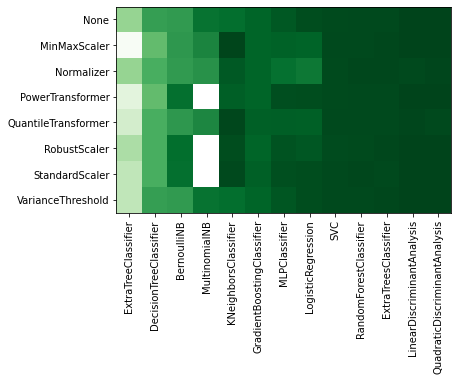

In [19]:

plot_matrix(Z_iris, None)

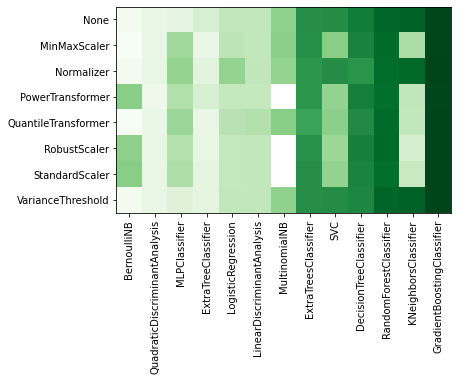

In [14]:
plot_matrix(Z_madelon)

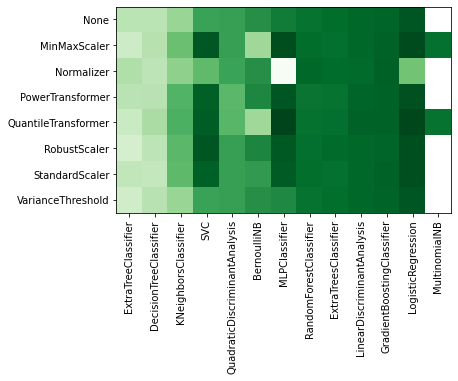

In [15]:
plot_matrix(Z_1487)

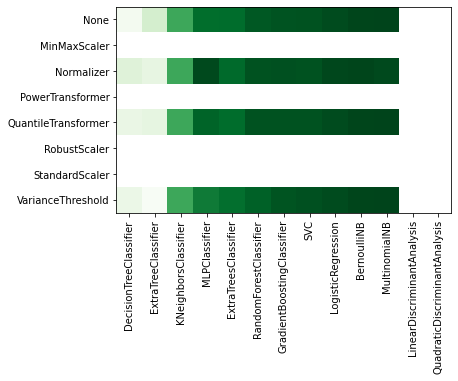

In [16]:
plot_matrix(Z_31)

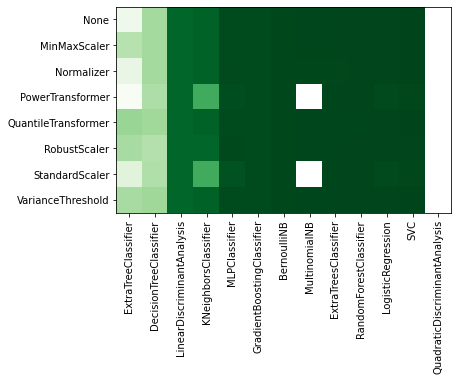

In [22]:
plot_matrix(Z_40975, None)